<a href="https://colab.research.google.com/github/amd257/COVID-detection-using-CNNs/blob/FinalRound/SequentialModel_ThreeLabel_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#Getting the compressed Three Label Classification Dataset file stored at: https://www.dropbox.com/s/n17olwvllwbnyl6/threelabeldataset.zip?dl=0
!wget https://www.dropbox.com/s/n17olwvllwbnyl6/threelabeldataset.zip?dl=0

--2021-03-08 15:22:42--  https://www.dropbox.com/s/n17olwvllwbnyl6/threelabeldataset.zip?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.1.18, 2620:100:6016:18::a27d:112
Connecting to www.dropbox.com (www.dropbox.com)|162.125.1.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/n17olwvllwbnyl6/threelabeldataset.zip [following]
--2021-03-08 15:22:42--  https://www.dropbox.com/s/raw/n17olwvllwbnyl6/threelabeldataset.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc3a1986c7a7abeead879759e76a.dl.dropboxusercontent.com/cd/0/inline/BKTGcqRxabXF3GP5bVfbphAn5xhWi9oi6gev0unkgWsaA4J-NhLRTels1Qg1v7SE3AH7kB-y3TUfp_fJkQl6AClhd6Puq72iOSV-fZnKsCGZnF6fBLmJi2Q-qo9p4VAQy5lvn83tApcEewDLlAR4MvxJ/file# [following]
--2021-03-08 15:22:42--  https://uc3a1986c7a7abeead879759e76a.dl.dropboxusercontent.com/cd/0/inline/BKTGcqRxabXF3GP5bVfbphAn5xhWi9oi6gev0unkgWsaA4J-NhLRTels1Q

In [ ]:
!unzip /content/threelabeldataset.zip?dl=0   #Extracting the compressed dataset file

In [3]:
#Importing all the libraries required for preprocessing, training and evaluation of the model
from tensorflow import keras
from tensorflow.keras import preprocessing
from tensorflow.keras.preprocessing import image_dataset_from_directory #Importing Functions for image preprocessing from keras
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau #Importing Functions for early stopping and learning rate reduction
from sklearn.utils import class_weight #Importing functions for computing class weights from scikit learn class_weight module
from keras.utils import plot_model
from keras.preprocessing import image
from keras.layers import *
from keras.models import * #Importing the functions required for creating the model
import matplotlib.pyplot as plt #For plotting the training and validation loss and accuracy graphs
import numpy as np
import pandas as pd

In [4]:
train_images_path = "ThreeLabelDataset/Train"
validation_images_path = "ThreeLabelDataset/Validation"
test_images_path = "ThreeLabelDataset/Test"
image_height = 256
image_width = 256

In [5]:
#Training data augmentation before feeding it to the CNN model
train_datagen = image.ImageDataGenerator(
    rescale = 1./255,
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True,  #flipping will add more variations to the data and it will help fight overfitting as welll
    )

#Preprocessing the training dataset
train_dataset= train_datagen.flow_from_directory(
    train_images_path,
    target_size = (image_height,image_width), 
    batch_size = 32,
    color_mode="grayscale",
    class_mode = "categorical",
    shuffle = True,
    seed =40
    )

inp_shape= train_dataset.image_shape
print("Input Shape: " , inp_shape)
print("Class Labels: ", train_dataset.class_indices)

Found 3108 images belonging to 3 classes.
Input Shape:  (256, 256, 1)
Class Labels:  {'COVID': 0, 'Normal': 1, 'ViralPneumonia': 2}


In [6]:
validation_datagen = image.ImageDataGenerator(rescale = 1./255) #Rescaling the validation images 

#Preprocessing the validation dataset
validation_dataset = validation_datagen.flow_from_directory(
    validation_images_path,
    target_size = (image_height,image_width),
    batch_size = 32,
    color_mode = "grayscale" ,
    class_mode = "categorical",
    shuffle = True,
    seed =40
    )

inp_shape= validation_dataset.image_shape
print("Input Shape: " , inp_shape)
print("Class Labels: ", validation_dataset.class_indices)

Found 388 images belonging to 3 classes.
Input Shape:  (256, 256, 1)
Class Labels:  {'COVID': 0, 'Normal': 1, 'ViralPneumonia': 2}


In [7]:
test_datagen = image.ImageDataGenerator(rescale = 1./255) #Rescaling the test images 

#Preprocessing the testing dataset
test_dataset = test_datagen.flow_from_directory(
    test_images_path,
    target_size = (image_height,image_width),
    batch_size = 32,
    color_mode = "grayscale" ,
    class_mode = "categorical",
    shuffle = True,
    seed =40
    )

inp_shape= test_dataset.image_shape
print("Input Shape: " , inp_shape)
print("Class Labels: ", test_dataset.class_indices)

Found 312 images belonging to 3 classes.
Input Shape:  (256, 256, 1)
Class Labels:  {'COVID': 0, 'Normal': 1, 'ViralPneumonia': 2}


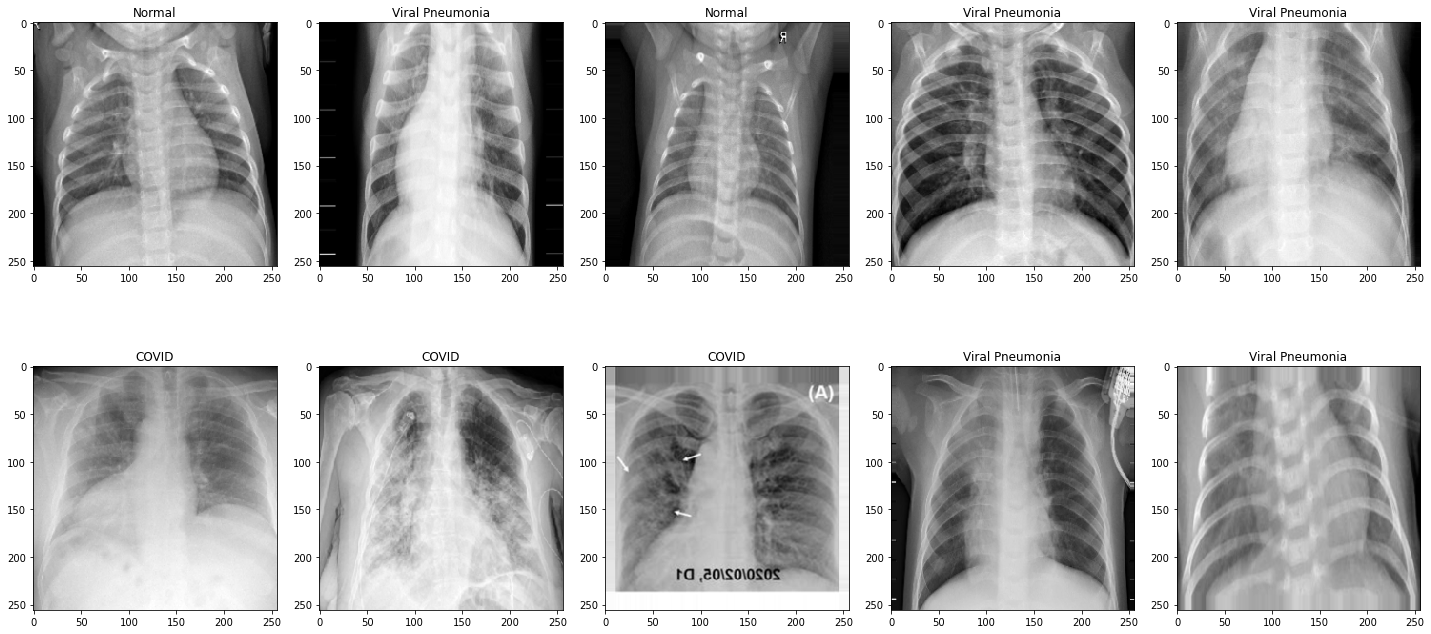

In [10]:
#Visualization of Preprocessed Data
plt.figure(figsize=(20, 10))
for i in range(0, 10):
    plt.subplot(2, 5, i+1)
    for X_batch, Y_batch in train_dataset:
        image = X_batch[0]        
        dic = {0: 'COVID', 1:'Normal', 2:'Viral Pneumonia'}
        img_index = np.argmax(Y_batch) #to get index of the image label 
        plt.title(label= dic.get(img_index))
        plt.axis('on')
        plt.imshow(np.squeeze(image),cmap='gray',interpolation='nearest')
        break
plt.tight_layout()
plt.show()

In [24]:
#CNN Sequential Model using Keras
#Multiple layers with different number of filters
#Layered architecture with 4 Convolutional Layers
seqmodel = Sequential()

seqmodel.add(Conv2D(32,
                 kernel_size = (3,3),
                 activation = 'relu',
                 input_shape =inp_shape)) 

seqmodel.add(Conv2D(64,
                 kernel_size = (3,3), 
                 activation = 'relu'))

seqmodel.add(MaxPooling2D(pool_size=(2,2)))

seqmodel.add(Dropout(0.25)) #to prevent overfitting

seqmodel.add(Conv2D(64,
                 kernel_size = (3,3),
                 activation='relu'))

seqmodel.add(MaxPooling2D(pool_size=(2,2)))

seqmodel.add(Dropout(0.25))

seqmodel.add(Conv2D(128,
                 kernel_size = (3,3), 
                 activation='relu'))

seqmodel.add(MaxPooling2D(pool_size=(2,2)))

seqmodel.add(Dropout(0.25))

seqmodel.add(Flatten())

seqmodel.add(Dense(64,activation='relu'))

seqmodel.add(Dropout(0.5)) #changed dropout value from 0.25 to 0.5 to further prevent overfitting

seqmodel.add(Dense(3,activation='softmax')) #activation function is softmax for multi class classification 

seqmodel.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy']) #configure the learning process

print(seqmodel.input.shape)
seqmodel.summary()

(None, 256, 256, 1)
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 254, 254, 32)      320       
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 252, 252, 64)      18496     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 126, 126, 64)      0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 126, 126, 64)      0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 124, 124, 64)      36928     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 62, 62, 64)        0         
_________________________________________________________________
dropout_9 (Dropout)          (None

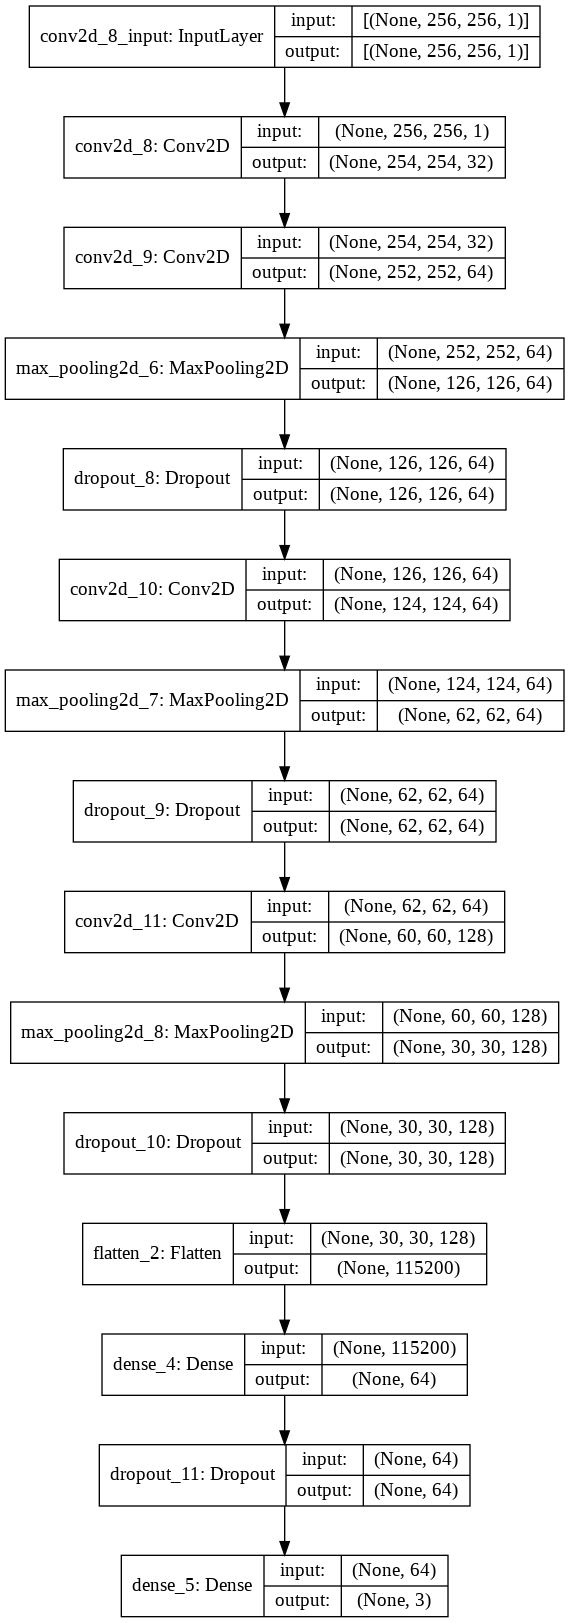

In [25]:
plot_model(seqmodel,show_shapes=True, show_layer_names=True, rankdir='TB', expand_nested=True)

In [26]:
STEP_SIZE_TRAIN=train_dataset.n//train_dataset.batch_size
STEP_SIZE_VALID=validation_dataset.n//validation_dataset.batch_size
print(STEP_SIZE_TRAIN)
print(STEP_SIZE_VALID)

97
12


In [27]:
#Defining functions for early stopping and adjusting the learning rate during model training 
earlyStop = EarlyStopping(monitor="val_loss", mode="min", patience=4, verbose= 1)
learningRateReduce = ReduceLROnPlateau(monitor='val_loss', patience = 2, verbose=1,factor=0.4, min_lr=0.0000001)
callbacksList = [ earlyStop, learningRateReduce]

In [28]:
#Assigning class weights using the compute class weights function
classWeights = class_weight.compute_class_weight('balanced', np.unique(train_dataset.classes), train_dataset.classes)
classWeightsDict = dict(enumerate(classWeights))
print("The class weights to be assigned to each label are:", classWeightsDict)

The class weights to be assigned to each label are: {0: 1.0791666666666666, 1: 0.9664179104477612, 2: 0.9628252788104089}


In [29]:
history = seqmodel.fit(
    train_dataset, 
    steps_per_epoch = STEP_SIZE_TRAIN, 
    epochs=100,
    validation_data = validation_dataset,
    validation_steps = STEP_SIZE_VALID,
    class_weight = classWeightsDict,
    callbacks=callbacksList
    )

Epoch 1/100
97/97 [==============================] - 85s 548ms/step - loss: 1.3277 - accuracy: 0.4697 - val_loss: 0.4801 - val_accuracy: 0.8516
Epoch 2/100
97/97 [==============================] - 53s 545ms/step - loss: 0.5796 - accuracy: 0.7293 - val_loss: 0.5059 - val_accuracy: 0.8464
Epoch 3/100
97/97 [==============================] - 53s 540ms/step - loss: 0.5561 - accuracy: 0.7722 - val_loss: 0.4705 - val_accuracy: 0.8620
Epoch 4/100
97/97 [==============================] - 53s 543ms/step - loss: 0.5215 - accuracy: 0.7716 - val_loss: 0.3127 - val_accuracy: 0.8906
Epoch 5/100
97/97 [==============================] - 54s 554ms/step - loss: 0.4840 - accuracy: 0.8088 - val_loss: 0.3119 - val_accuracy: 0.8984
Epoch 6/100
97/97 [==============================] - 54s 553ms/step - loss: 0.4320 - accuracy: 0.8333 - val_loss: 0.3840 - val_accuracy: 0.9010
Epoch 7/100
97/97 [==============================] - 53s 545ms/step - loss: 0.4228 - accuracy: 0.8365 - val_loss: 0.3139 - val_accuracy:

In [30]:
seqmodel.save('SequentialModel_ThreeLabelFinal.h5') #Saving the model

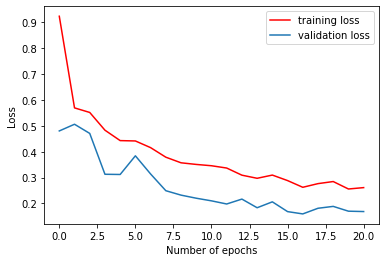

In [31]:
#Plotting the graph for training and validation loss

plt.plot(history.history['loss'],'r',label='training loss')
plt.plot(history.history['val_loss'],label='validation loss')
plt.xlabel('Number of epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

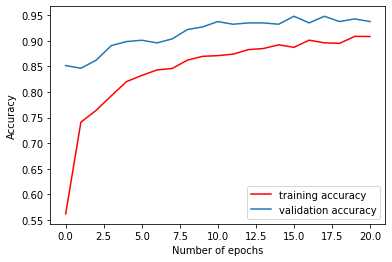

In [32]:
#Plotting the graph for training and validation accuracy
plt.plot(history.history['accuracy'],'r',label='training accuracy')
plt.plot(history.history['val_accuracy'],label='validation accuracy')
plt.xlabel('Number of epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [34]:
testingAccuracy = seqmodel.evaluate(test_dataset) #Evaluating the model on the testing dataset
print("The Sequential Model 2.0 has a testing accuracy of:", testingAccuracy[1]*100, "%")

10/10 [==============================] - 5s 461ms/step - loss: 0.1701 - accuracy: 0.9327
The Sequential Model 2.0 has a testing accuracy of: 93.2692289352417 %
